# Load data


In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dwiamalia13","key":"03c948f3c71810d90d61e2f849a9649e"}'}

In [2]:
!mkdir -p ~/.kaggle  # Membuat direktori .kaggle
!mv kaggle.json ~/.kaggle/  # Memindahkan kaggle.json ke direktori tersebut
!chmod 600 ~/.kaggle/kaggle.json  # Mengatur izin akses agar aman
!kaggle datasets download -d vijaykumar1799/face-mask-detection --unzip --force

Dataset URL: https://www.kaggle.com/datasets/vijaykumar1799/face-mask-detection
License(s): CC0-1.0
 95% 210M/222M [00:00<00:00, 219MB/s]
100% 222M/222M [00:01<00:00, 221MB/s]


In [3]:
ls Dataset

mask_weared_incorrect/  with_mask/  without_mask/


In [4]:
import os
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
def load_data():
    img_paths = []

    directories = ['Dataset/mask_weared_incorrect/',
                   'Dataset/with_mask/',
                   'Dataset/without_mask/']

    for folder in directories:
        for img_path in os.listdir(folder):
            if folder == 'Dataset/mask_weared_incorrect/':
                label = 'mask_weared_incorrect'
            elif folder == 'Dataset/with_mask/':
                label = 'with_mask'
            else:
                label = 'without_mask'

            img_paths.append([folder + img_path, label])

    X = np.array([cv2.imread(img_path[0]) for img_path in img_paths]) / 255.0
    y = np.array([label[1] for label in img_paths])

    encoded_y = []
    for label in y:
        # labels will be encoded as such: 0=mask_weared_incorrect, 1=with_mask, 2=without_mask
        if label == 'mask_weared_incorrect':
            encoded_y.append(0)
        elif label == 'with_mask':
            encoded_y.append(1)
        else:
            encoded_y.append(2)

    encoded_y = np.array(encoded_y)
    categorical_y = to_categorical(encoded_y, num_classes=3)

    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Encoded y shape: {encoded_y.shape}")
    print(f"Categorical labels shape: {categorical_y.shape}")

    return X, categorical_y, img_paths

In [5]:
X, y, img_paths =load_data()

X shape: (8982, 128, 128, 3)
y shape: (8982,)
Encoded y shape: (8982,)
Categorical labels shape: (8982, 3)


In [6]:
from sklearn.model_selection import train_test_split
def split_dataset(data, labels):
    x_train, x_, y_train, y_ = train_test_split(data, labels, test_size=0.3, random_state=42, shuffle=True)
    x_val, x_test, y_val, y_test = train_test_split(x_, y_, test_size=0.333, random_state=42, shuffle=True)

    print(f"\nTraining data: {x_train.shape},  labels: {y_train.shape}")
    print(f"Validation data: {x_val.shape},  labels: {y_val.shape}")
    print(f"Testing data: {x_test.shape},  labels: {y_test.shape}")

    return x_train, y_train, x_val, y_val, x_test, y_test

In [7]:
classes = ['mask_weared_incorrect', 'with_mask', 'without_mask']
x_train, y_train, x_val, y_val, x_test, y_test = split_dataset(data=X, labels=y)


Training data: (6287, 128, 128, 3),  labels: (6287, 3)
Validation data: (1797, 128, 128, 3),  labels: (1797, 3)
Testing data: (898, 128, 128, 3),  labels: (898, 3)


In [8]:
import matplotlib.pyplot as plt
def display_random_set(data, labels, classes):
    # Function will display 6 random images
    plt.figure(figsize=(10, 5))
    for i in range(6):
        plt.subplot(2, 3, (i+1))
        random_val = np.random.randint(low=0, high=len(data))
        img = data[random_val]
        plt.imshow(img)
        plt.axis(False)
        plt.title(classes[np.argmax(labels[random_val])])
    plt.show()

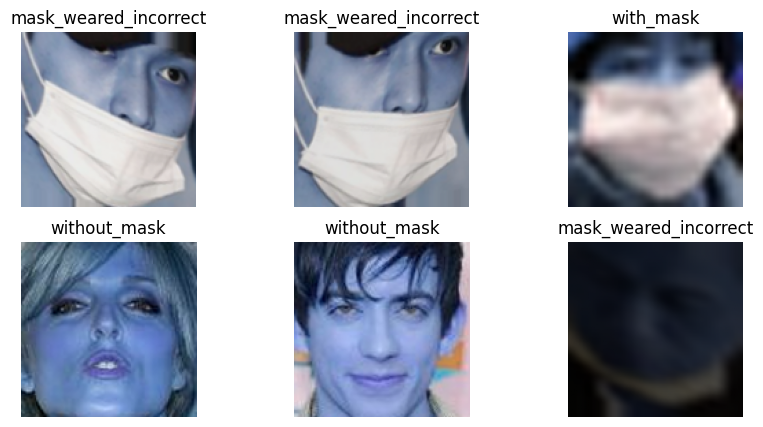

In [9]:
display_random_set(data=x_train, labels=y_train, classes=classes)

In [10]:
from tensorflow.keras import layers, models

def build_model(input_dim, num_classes):
    model = models.Sequential([
        layers.Conv2D(16, (2, 2), padding='same', activation='relu', input_shape=input_dim),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),

        layers.Conv2D(32, (2, 2), padding='same', activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5),

        layers.Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='sgd',
                  loss='categorical_crossentropy',
                  metrics=['categorical_accuracy', 'accuracy'])

    model.summary()

    return model

model = build_model(input_dim=x_train[0].shape, num_classes=len(classes))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 16)        │             208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 32)          │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       2,097,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,108,211 (8.04 MB)

 Trainable params: 2,108,115 (8.04 MB)

 Non-trainable params: 96 (384.00 B)

In [11]:
import pickle
def save_history_file(filename_to_save_as, history):
    pickle_out = open(filename_to_save_as, 'wb')
    pickle.dump(history.history, pickle_out)
    pickle_out.close()


def load_history_file(history_filename):
    pickle_in = open(history_filename, 'rb')
    saved_history = pickle.load(pickle_in)
    return saved_history

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint
epochs = 20
# Membuat callback checkpoint
#checkpoint = ModelCheckpoint(filepath='./mask_status.h5', monitor='val_loss', verbose=1, save_best_only=True)
checkpoint_callback = ModelCheckpoint(
    filepath='./mask_status.weights.h5',
    save_weights_only=True,
    verbose=1,
    monitor='val_loss',
)
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=epochs, verbose=1, validation_data=(x_val, y_val),callbacks=[checkpoint_callback])

save_history_file(filename_to_save_as='./mask_status.pkl', history=history)
history_loaded = load_history_file(history_filename='./mask_status.pkl')

Epoch 1/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 776ms/step - accuracy: 0.7335 - categorical_accuracy: 0.7335 - loss: 0.7216
Epoch 1: saving model to ./mask_status.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 91s 891ms/step - accuracy: 0.7344 - categorical_accuracy: 0.7344 - loss: 0.7191 - val_accuracy: 0.5821 - val_categorical_accuracy: 0.5821 - val_loss: 0.9636
Epoch 2/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 751ms/step - accuracy: 0.9041 - categorical_accuracy: 0.9041 - loss: 0.2799
Epoch 2: saving model to ./mask_status.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 138s 856ms/step - accuracy: 0.9042 - categorical_accuracy: 0.9042 - loss: 0.2796 - val_accuracy: 0.6639 - val_categorical_accuracy: 0.6639 - val_loss: 0.7021
Epoch 3/20
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 749ms/step - accuracy: 0.9403 - categorical_accuracy: 0.9403 - loss: 0.1753
Epoch 3: saving model to ./mask_status.weights.h5
99/99 ━━━━━━━━━━━━━━━━━━━━ 80s 808ms/step - accuracy: 0.9404 - categorical_accuracy: 0.9404 - loss: 0.1752 - val_accuracy: 0.7023 

In [16]:
# Save model in HDF5 format
model.save('mask_classifier.keras')

29/29 ━━━━━━━━━━━━━━━━━━━━ 7s 233ms/step - accuracy: 0.9751 - categorical_accuracy: 0.9751 - loss: 0.0833
Test Loss: 0.0891
Test Accuracy: 0.9766
29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step


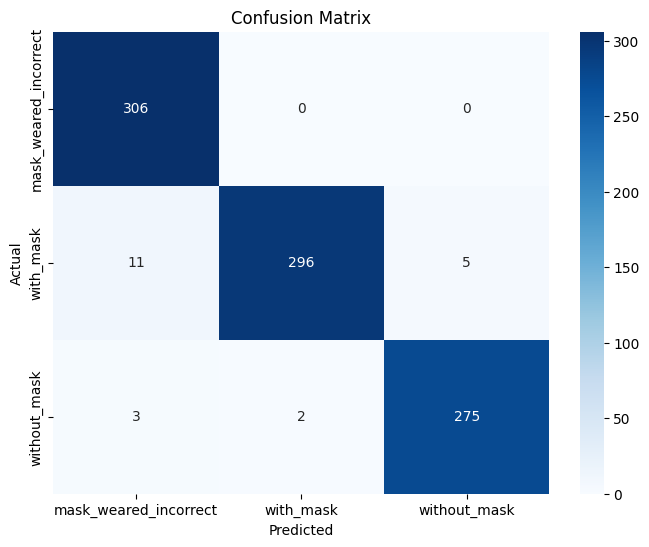

                       precision    recall  f1-score   support

mask_weared_incorrect       0.96      1.00      0.98       306
            with_mask       0.99      0.95      0.97       312
         without_mask       0.98      0.98      0.98       280

             accuracy                           0.98       898
            macro avg       0.98      0.98      0.98       898
         weighted avg       0.98      0.98      0.98       898



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluasi model
test_results = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_results[0]:.4f}")
print(f"Test Accuracy: {test_results[1]:.4f}")

# Prediksi label
y_pred = np.argmax(model.predict(x_test), axis=1) # Convert predictions to class labels
y_true = np.argmax(y_test, axis=1)  # Convert true labels to class labels

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=classes))


In [23]:
def plot_curves(history):
    plt.figure(figsize=(14, 10))
    sns.set_style(style='dark')
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.xlabel('Iterations')
    plt.ylabel('Error')
    plt.title('Training & Validation Loss')
    plt.legend(['Train loss', 'Validation loss'])

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Accuracy & Validation Accuracy')
    plt.legend(['Accuracy', 'Validation Accuracy'])

    plt.show()

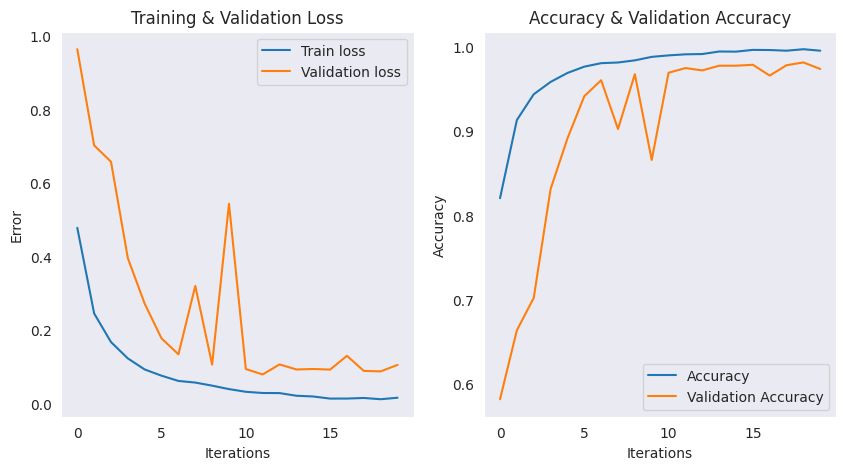

In [17]:
from tensorflow.keras.models import load_model
import seaborn as sns
classifier = load_model(filepath='./mask_classifier.keras')
plot_curves(history=history_loaded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


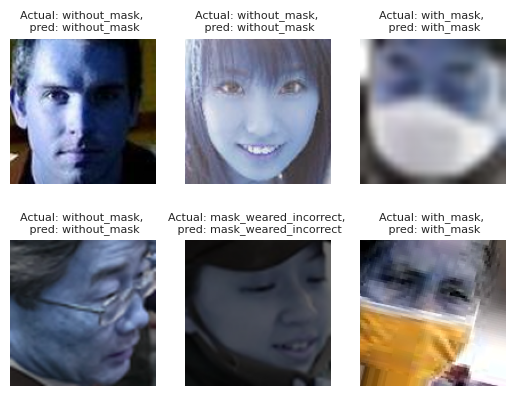

In [27]:
# prediction on 6 random images
# Changed loop to iterate only 6 times (or less)
for i in range(6):
    random_val = np.random.randint(low=0, high=len(x_test))
    image = x_test[random_val]
    true_label = np.argmax(y_test[random_val])
    predict_label = np.argmax(classifier.predict(np.expand_dims(image, axis=0)))
    plt.subplot(2, 3, (i+1))
    plt.imshow(image)
    plt.axis(False)
    # Reduced font size to 8
    plt.title(f"Actual: {classes[true_label]}, \n pred: {classes[predict_label]}", fontsize=8)
plt.show()